In [3]:
import os
import glob
import imageio
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline

HOLDOUT = 10
R = 0.01

In [8]:
os.chdir("C:\\Users\\USUARIO\\Desktop\\eigenfaces\\PIC-EigenfacesFracionario\\")
os.getcwd()

'C:\\Users\\USUARIO\\Desktop\\eigenfaces\\PIC-EigenfacesFracionario'

In [13]:
def CarregarYaleFaces():
    files = glob.glob("databases/yalefaces/*")
    images_yale = [np.array(imageio.mimread(file))[0] for file in files]
    images_yale_resized = [cv2.resize(image, dsize=(28, 23), interpolation=cv2.INTER_CUBIC) for image in images_yale]
    images_yale_resized = np.array(images_yale_resized)
    images_yale_flatten = [image.flatten() for image in images_yale_resized]
    images_yale_flatten = np.array(images_yale_flatten)
    print('#Amostras (n): '+str(images_yale_flatten.shape[0]))
    print('#Features (m): '+str(images_yale_flatten.shape[1]))
    Y = [f.split('.')[0] for f in files]
    return images_yale_flatten, Y

In [14]:
def FPCA(X, r, k):
    X = [np.power(x, r) for x in X]
    X = np.array(X)
    mean_vector = np.mean(X.T, axis = 1)                #cria o vetor medio
    mean_vector = np.power(mean_vector, r)
    centered_matrix = X - mean_vector                   #cria a matriz de diferencas entre os data points e o vetor medio
    centered_matrix = centered_matrix.astype(None)
    #cov_matrix = np.cov(centered_matrix.T)              #matriz de covariancia
    cov_matrix = centered_matrix.T.dot(centered_matrix)              #matriz de covariancia
    #print('cov_matrix shape: '+str(cov_matrix.shape))
    values, vectors = np.linalg.eig(cov_matrix)         #autovalores e autovetores
    return np.real(vectors.T.dot(centered_matrix.T).T)[:,:k]

In [29]:
def Eigenfaces2(X, k):
    n = len(X)
    mean_vector = np.mean(X, axis = 0)
    centered_matrix = X - mean_vector
    centered_matrix = centered_matrix.astype(None)
    D = centered_matrix.dot(centered_matrix.T)              #matriz de covariancia
    escalar = 1. / n
    D = escalar * D
    values_d, vectors_d = np.linalg.eig(D)
    vectors_c_ = (1. / np.power(n * values_d,0.5)) *  centered_matrix.T.dot(vectors_d)   #eq 7
    np.real(vectors_c_)
    return np.real(vectors_c_.T.dot(centered_matrix.T).T)[:,:k]

In [30]:
def Eigenfaces(X, k):
    mean_vector = np.mean(X.T, axis = 1)                #cria o vetor medio
    centered_matrix = X - mean_vector                   #cria a matriz de diferencas entre os data points e o vetor medio
    centered_matrix = centered_matrix.astype(None)
    cov_matrix = centered_matrix.dot(centered_matrix.T)              #matriz de covariancia
    #print('cov_matrix eigenfaces shape: '+str(cov_matrix.shape))
    values, vectors = np.linalg.eig(cov_matrix)         #autovalores e autovetores
    #print('values: '+str(values.shape))
    #print('vectors: '+str(vectors.shape))
    #print('vector'+str(vectors[:,0].shape))
    vectors_ = []
    '''
    for i in range(vectors.shape[0]):
        N = vectors.shape[0]
        a = 1 / np.power((N * values[i]),0.5)
        #b = X[i] - mean_vector
        #print(X[i].shape)
        #print(mean_vector.shape)
        #print('centered_matrix:'+str(centered_matrix.shape))
        #print(vectors[:,i].shape)
        vectors_.append(a * centered_matrix.dot(vectors[:,i]))
    '''
    N = vectors.shape[0]
    a = 1 / np.power((N * values),0.5)
    vectors_ = a * centered_matrix.T.dot(vectors)
    vectors_ = np.array(vectors_)
    #print(vectors.shape)
    #print(vectors_.shape)
    return np.real(vectors_.T.dot(centered_matrix.T).T)[:,:k]

In [31]:
def F_Eigenfaces(X, r, k):
    X = [np.power(x, r) for x in X]
    X = np.array(X)
    mean_vector = np.mean(X.T, axis = 1)                #cria o vetor medio
    mean_vector = np.power(mean_vector, r)
    centered_matrix = X - mean_vector                   #cria a matriz de diferencas entre os data points e o vetor medio
    centered_matrix = centered_matrix.astype(None)
    cov_matrix = centered_matrix.dot(centered_matrix.T)              #matriz de covariancia
    #print('cov_matrix eigenfaces shape: '+str(cov_matrix.shape))
    values, vectors = np.linalg.eig(cov_matrix)         #autovalores e autovetores
    #print('values: '+str(values.shape))
    #print('vectors: '+str(vectors.shape))
    #print('vector'+str(vectors[:,0].shape))
    vectors_ = []
    '''
    for i in range(vectors.shape[0]):
        N = vectors.shape[0]
        a = 1 / np.power((N * values[i]),0.5)
        #b = X[i] - mean_vector
        #print(X[i].shape)
        #print(mean_vector.shape)
        #print('centered_matrix:'+str(centered_matrix.shape))
        #print(vectors[:,i].shape)
        vectors_.append(a * centered_matrix.dot(vectors[:,i]))
    '''
    N = vectors.shape[0]
    a = 1 / np.power((N * values),0.5)
    vectors_ = a * centered_matrix.T.dot(vectors)
    vectors_ = np.array(vectors_)
    #print(vectors.shape)
    #print(vectors_.shape)
    return np.real(vectors_.T.dot(centered_matrix.T).T)[:,:k]

In [32]:
def AvaliarClassificadores(X, Y):
    scores_1nn = []
    
    for i in range(HOLDOUT):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=0)
        clf_1nn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
        scores_1nn.append(clf_1nn.score(X_test, y_test))

    scores_1nn = np.array(scores_1nn).mean() * 100
    return scores_1nn

In [33]:
images_yale, Y = CarregarYaleFaces()
acc_yale = []
acc_att = []
acc_sheffield = []
for n in range(1, 71):
    X_fpca = FPCA(images_yale, R, n)
    X_eige = Eigenfaces2(images_yale, n)
    X_feig = F_Eigenfaces(images_yale, R, n)
    s_fpca = AvaliarClassificadores(X_fpca, Y)
    s_eige = AvaliarClassificadores(X_eige, Y)
    s_feig = AvaliarClassificadores(X_feig, Y)
    acc_yale.append([s_fpca,s_eige,s_feig])
acc_yale = np.array(acc_yale)

#Amostras (n): 165
#Features (m): 644


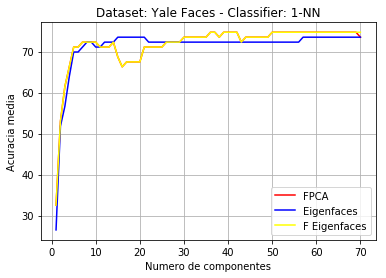

In [34]:
x = np.arange(1, 71)
#plt.figure(figsize=(20,15))
plt.title("Dataset: Yale Faces - Classifier: 1-NN")
plt.plot(x, acc_yale[:,0], color='red')
plt.plot(x, acc_yale[:,1], color='blue')
plt.plot(x, acc_yale[:,2], color='yellow')
plt.ylabel('Acuracia media')
plt.xlabel('Numero de componentes')
plt.legend(labels=['FPCA','Eigenfaces','F Eigenfaces'])
plt.grid()
plt.show()